In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Setup matplotlib to display in notebook:
%matplotlib inline

This notebook contains code for testing time series methods of detecting anomalies in KWH consumption in NYCHA dataset prorated and imputed to calendar months:
    1. Time series decomposition
    2. Time series SARIMA model 
    3. Time series VAR model

#### Import pickled file of prorated and imputed bills

In [4]:
df_prorated_imputed = pd.read_pickle("../output/NYCHA_Electricity_2010_to_2018_df_prorated_kwh_imputed")
df_prorated_imputed.head()

,Building_Meter,Month,Month_Type,Month_#_Days,Prorated_Days,Gap_Days,Gap_Type,Prorated_KWH,Imputed_KWH
0,165.0 - BLD 04_99273488,2009-12-01,First_Month,31,9.0,0.0,No Gap,19694.117647,67835.294118
1,165.0 - BLD 04_99273488,2010-01-01,Month_In_The_Middle,31,31.0,0.0,No Gap,68283.025210,68283.025210
2,165.0 - BLD 04_99273488,2010-02-01,Month_In_The_Middle,28,28.0,0.0,No Gap,61071.133005,61071.133005
3,165.0 - BLD 04_99273488,2010-03-01,Month_In_The_Middle,31,31.0,0.0,No Gap,58011.118077,58011.118077
4,165.0 - BLD 04_99273488,2010-04-01,Month_In_The_Middle,30,30.0,0.0,No Gap,55164.054336,55164.054336


In [6]:
# separate out the first building records for model testing
df_one_building = df_prorated_imputed[df_prorated_imputed['Building_Meter']=='165.0 - BLD 04_99273488']

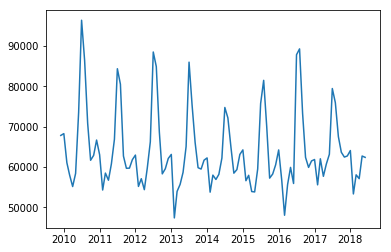

In [18]:
plt.plot(df_one_building['Month'],df_one_building['Imputed_KWH'])

#### 1.Decomposition

The decomposition method is aimed at building a confidence interval around the residuals to detect whether the residual of a new observation is an anomaly or not.

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

/Users/crystal-pro/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [31]:
df_for_decompose = pd.DataFrame({'Imputed_KWH':np.asarray(df_one_building['Imputed_KWH'])}, index = df_one_building['Month'])

In [34]:
result = seasonal_decompose(df_for_decompose, model='additive',freq=12)

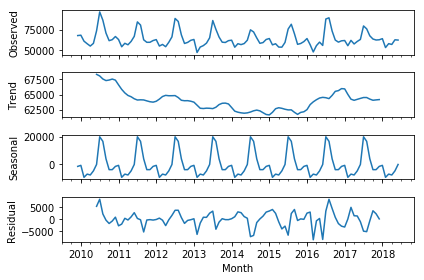

In [158]:
result.plot();

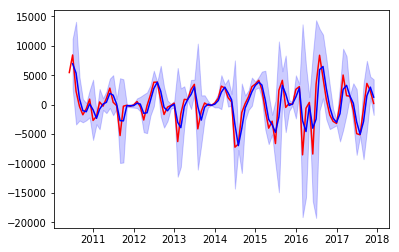

In [165]:
ma = result.resid.rolling(2).mean()

mstd = result.resid.rolling(2).std()

plt.figure()
plt.plot(result.resid.index, result.resid, 'r')
plt.plot(ma.index, ma, 'b')
plt.fill_between(mstd.index, (ma-2*mstd)['Imputed_KWH'], (ma+2*mstd)['Imputed_KWH'], color='b', alpha=0.2);

#### 2.SARIMA

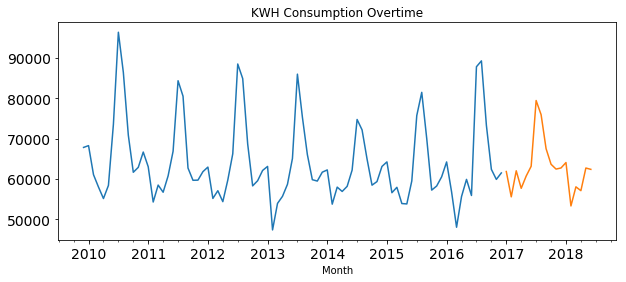

In [167]:
# determine the cutoff for one building train and test split
# we will be using 2017-01-01 as cutoff
train_set = df_one_building[0:85].set_index('Month')
test_set = df_one_building[85:].set_index('Month')
train_set['Imputed_KWH'].plot(figsize=(10,4), title= 'KWH Consumption Overtime', fontsize=14)
test_set['Imputed_KWH'].plot(figsize=(10,4), title= 'KWH Consumption Overtime', fontsize=14)
# plot the Imputed_KWH by train and test to see if train is indicative enough
plt.show();

In [69]:
# define a test_stationarity function to validate assumption for time series modeling
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    #rolmean = pd.rolling_mean(timeseries, window=12)
    rolmean = timeseries.rolling(12).mean()
    #rolstd = pd.rolling_std(timeseries, window=12)
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

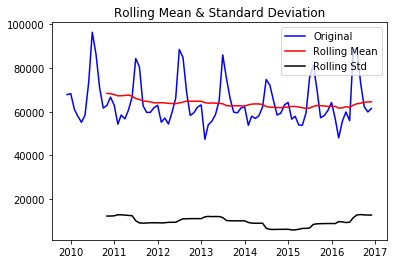

Results of Dickey-Fuller Test:
Test Statistic                 -2.616153
p-value                         0.089705
#Lags Used                     12.000000
Number of Observations Used    72.000000
Critical Value (1%)            -3.524624
Critical Value (5%)            -2.902607
Critical Value (10%)           -2.588679
dtype: float64


In [70]:
test_stationarity(train_set['Imputed_KWH'])

In [56]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

In [58]:
lag_acf = acf(train_set['Imputed_KWH'], nlags=10)
lag_pacf = pacf(train_set['Imputed_KWH'], nlags=10, method='ols')

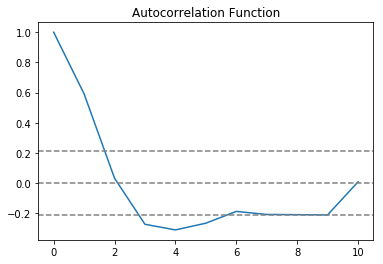

In [173]:
#Plot ACF: 
plt.plot(lag_acf);
plt.axhline(y=0,linestyle='--',color='gray');
plt.axhline(y=(-1.96/np.sqrt(len(train_set['Imputed_KWH']))),linestyle='--',color='gray');
plt.axhline(y=(1.96/np.sqrt(len(train_set['Imputed_KWH']))),linestyle='--',color='gray');
plt.title('Autocorrelation Function');

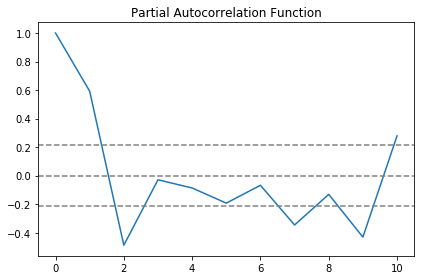

In [172]:
#Plot PACF:
plt.plot(lag_pacf);
plt.axhline(y=0,linestyle='--',color='gray');
plt.axhline(y=-1.96/np.sqrt(len(train_set['Imputed_KWH'])),linestyle='--',color='gray');
plt.axhline(y=1.96/np.sqrt(len(train_set['Imputed_KWH'])),linestyle='--',color='gray');
plt.title('Partial Autocorrelation Function');
plt.tight_layout();

In [81]:
from statsmodels.tsa.statespace import sarimax

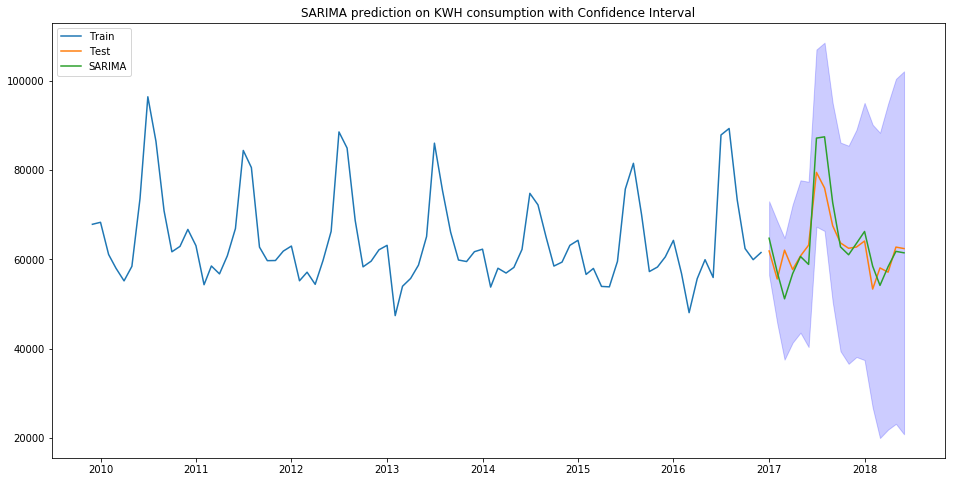

In [224]:
y_hat_avg = test_set.copy()
fit1 = sarimax.SARIMAX(train_set['Imputed_KWH'], order=(2, 1, 2), seasonal_order=(2,1,1,12)).fit()
#y_hat_avg['SARIMA'] = fit1.predict(start="2017-01-01", end="2018-06-01", dynamic=True)
#y_hat_avg['SARIMA'] = fit1.forecast(steps=len(test_set.index))

model_result = fit1.get_forecast(steps=len(test_set.index))
y_hat_avg['SARIMA'] = model_result.predicted_mean
pred_ci = model_result.conf_int()

plt.figure(figsize=(16,8))
plt.plot(train_set['Imputed_KWH'], label='Train')
plt.plot(test_set['Imputed_KWH'], label='Test')
plt.plot(y_hat_avg['SARIMA'], label='SARIMA')
plt.fill_between(y_hat_avg['SARIMA'].index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='b', alpha=0.2)
plt.title("SARIMA prediction on KWH consumption with Confidence Interval")
plt.legend(loc='upper left')
plt.show();

In [104]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(test_set['Imputed_KWH'], y_hat_avg['SARIMA']))
print(rms)

4826.762609066387


#### 3.VAR